In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [35]:
import matplotlib.pyplot as plt

import numpy as np

import darkhistory.physics as phys
import main
# import darkhistory.history.tla as tla
from scipy import integrate
import scipy.special

The following units are being used
$$
\begin{alignat}{2}
M_0 &= 4 \pi \rho_s r_s^3 \\
t_0 &= (4\pi G \rho_s)^{-1/2} \\ 
\nu_0 &= r_s/t_0 \\
(\sigma/m)_0 &= (r_s \rho_s)^{-1} \\
L_0 &= (4\pi)^{5/2}G^{3/2}\rho_s^{5/2} r_s^5 \\
C_0 &= (4\pi G)^{3/2}\rho_s^{5/2}r_s^2
\end{alignat}
$$
Do we set $\rho_s = r_s = 1$?

In [354]:
### Constants ###
#g to kg (1e-3) to J (c^-2) to eV (e^-1)
g_to_eV = 1e-3/phys.c**2/phys.ele
G = 1 #Newton's constant

#Particle Physics
sig_m  = 3/g_to_eV # sigma / m
sigp_m = sig_m
nu_loss = 13*1e5/phys.c #13 km/s


def C(rho,nu):
    ratio = np.divide(nu_loss,nu, where=(nu!=0), out=1e3*np.ones_like(nu))**2
    return rho**2 * sigp_m * 4*nu*nu_loss**2/np.sqrt(np.pi) * (1+ratio) * np.exp(-ratio)
    

def kappa_m(rho, nu, beta=0.6):
    klmfp_m = 0.27 * beta * rho * nu**3 * sig_m
    ksmfp_m = 2.1/sig_m
    mask = klmfp_m==0
    
    k = np.zeros_like(klmfp_m)
    k[~mask] = (klmfp_m[~mask]**(-1) + ksmfp_m**(-1))**(-1)
    return k

def get_L(rho, nu, r):
    T_m = nu**2 # T/m
    dT_mdr = np.append(np.diff(T_m)/np.diff(r), 
                       (T_m[-1]-T_m[-2])/(r[-1]-r[-2]))
    
    return -4*np.pi*r**2 * kappa_m(rho, nu) * dT_mdr
    
def eta(rho, nu,alpha=4/np.sqrt(np.pi)):
    v_bar = np.sqrt(3)*nu
    return 1/3 * alpha*sig_m * v_bar * (
        alpha*sig_m**2 + 4*np.pi*G/rho/nu**2
    )**(-1)

def rho_NFW(r):
    inv = r * (r+1)**2
    return 1/inv

def j_init(r, js=1, r_ratio=3,thetas=1):#theta
    rtmp = r*r_ratio
    return js*(rtmp)**2/(1+rtmp)**4 # * np.sin(theta/thetas)**2

def integrated_NFW(r):
    return 4*np.pi*(np.log(r+1)-r/(r+1))

def nu_init(r,rho=None,M=None,switch=False):
    if switch:
        if True:
            nu = np.zeros_like(r)
            grav = M*rho/r**2
            # set the pressure at the edge to zero, 
            # then require that dpdr = -grav

            for i in np.arange(len(r)-1):
                nu[-2-i] = np.sqrt((grav[-1-i]*(r[-1-i]-r[-2-i]) 
                                   + rho[-1-i]*nu[-1-i]**2)/rho[-2-i])

            return nu
        else:
            #Initial Condition: at r=0, p=0
            nu = np.zeros_like(r)
            grav = M*rho/r**2
            # set the dispersion at the center to zero
            nu[0] = np.sqrt(grav[0]*(r[0]-0)/rho[0])
            for i in np.arange(len(r)-1):
                nu[i+1] = np.sqrt((rho[i]*nu[i]**2
                    -grav[i+1]*(r[i+1]-r[i]))/rho[i+1])

            return nu
            
            
    else:
        pre = 2/r
        term1 = 6 * r**2 * (r+1)**2 * scipy.special.spence(1+r)
        term2p1 = 3 * (r+1) * r**2 * np.log(r+1)**2
        term2p2 = (r+1) * r**2 * (6*np.log(1/r + 1) + 5*np.log(r))
        term2p3 = -np.log(r+1)*(r*(r*(5*r+11)+3)-1)
        term3 = r*(r*(np.pi**2*(r+1)**2 - 7*r - 9) - 1)

        return np.sqrt(
            pre*(term1 + (r+1)*(term2p1+term2p2+term2p3) + term3)
        )

In [306]:
def rsq_rho_NFW(r):
    return 4*np.pi*r**2 * rho_NFW(r)
print(integrate.quad(rsq_rho_NFW,0,2),integrated_NFW(2))

(5.427988771320028, 7.152737876055877e-11) 5.42798877132003


In [348]:
#Initialize
N = 150
r = 10**np.arange(-2,3,5/N)
rho = rho_NFW(r)
M = integrated_NFW(r)
nu = nu_init(r, rho, M, switch=True)
# print(nu)

L = get_L(rho, nu, r)
u = 3*nu**2/2
du_dt = (
    np.append(np.diff(L)/np.diff(M), (L[-1]-L[-2])/(M[-1]-M[-2]))
    + C(rho,nu)/rho
)

# print(np.diff(rho*nu**2)/np.diff(r)/(M*rho/r**2)[1:]+1)

mask = (u!=0)
dt = np.min(np.abs(u[mask]/du_dt[mask])*1e-3)
du = du_dt*dt

nu_p =  np.sqrt(2/3*(u - du))
print(np.diff(rho*nu_p**2)/np.diff(r)/(M*rho/r**2)[1:]+1)

[ 4.89505016e-03  4.32471213e-03  3.82052156e-03  3.37484643e-03
  2.98093056e-03  2.63279357e-03  2.32514228e-03  2.05329213e-03
  1.81309755e-03  1.60089033e-03  1.41342488e-03  1.24782987e-03
  1.10156528e-03  9.72384401e-04  8.58300168e-04  7.57555325e-04
  6.68596010e-04  5.90048357e-04  5.20697782e-04  4.59470625e-04
  4.05417913e-04  3.57700970e-04  3.15578686e-04  2.78396243e-04
  2.45575135e-04  2.16604339e-04  1.91032498e-04  1.68461000e-04
  1.48537864e-04  1.30952318e-04  1.15430012e-04  1.01728775e-04
  8.96348690e-05  7.89596722e-05  6.95367432e-05  6.12192291e-05
  5.38775705e-05  4.73974737e-05  4.16781170e-05  3.66305656e-05
  3.21763699e-05  2.82463277e-05  2.47793894e-05  2.17216913e-05
  1.90257022e-05  1.66494693e-05  1.45559531e-05  1.27124405e-05
  1.10900281e-05  9.66316583e-06  8.40925664e-06  7.30830319e-06
  6.34259823e-06  5.49645248e-06  4.75595602e-06  4.10876936e-06
  3.54394024e-06  3.05174364e-06  2.62354152e-06  2.25166026e-06
  1.92928318e-06  1.65035

In [349]:
nu_p/nu-1

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([-5.00125063e-04, -4.50311653e-04, -4.05502691e-04, -3.65189990e-04,
       -3.28917455e-04, -2.96275701e-04, -2.66897228e-04, -2.40452101e-04,
       -2.16644081e-04, -1.95207155e-04, -1.75902424e-04, -1.58515320e-04,
       -1.42853103e-04, -1.28742626e-04, -1.16028322e-04, -1.04570407e-04,
       -9.42432618e-05, -8.49339851e-05, -7.65410944e-05, -6.89733604e-05,
       -6.21487611e-05, -5.59935438e-05, -5.04413837e-05, -4.54326280e-05,
       -4.09136183e-05, -3.68360821e-05, -3.31565861e-05, -2.98360462e-05,
       -2.68392866e-05, -2.41346448e-05, -2.16936160e-05, -1.94905342e-05,
       -1.75022853e-05, -1.57080495e-05, -1.40890697e-05, -1.26284436e-05,
       -1.13109362e-05, -1.01228117e-05, -9.05168204e-06, -8.08637109e-06,
       -7.21679184e-06, -6.43383653e-06, -5.72927752e-06, -5.09567826e-06,
       -4.52631323e-06, -4.01509605e-06, -3.55651487e-06, -3.14557443e-06,
       -2.77774416e-06, -2.44891163e-06, -2.15534106e-06, -1.89363616e-06,
       -1.66070706e-06, -

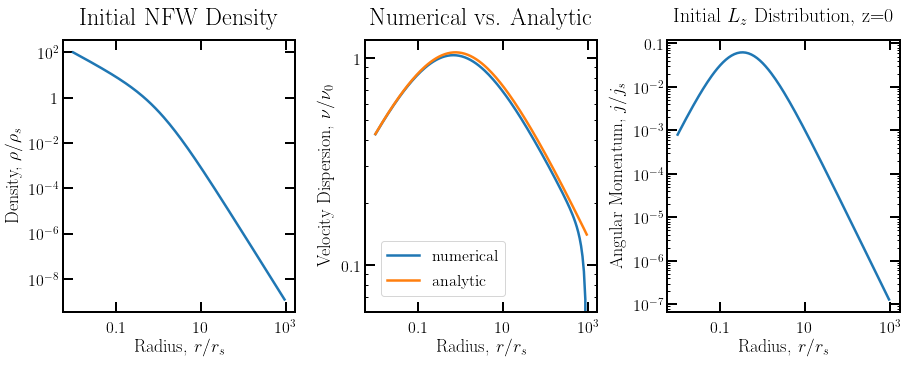

In [363]:
fig, axarr = plt.subplots(1, 3, figsize=(15,5))

axarr[0].loglog()
axarr[0].plot(r,rho_NFW(r))
axarr[0].set_xlabel(r'Radius, $r/r_s$')
axarr[0].set_ylabel(r'Density, $\rho/\rho_s$')
axarr[0].set_title('Initial NFW Density')

axarr[1].loglog()
axarr[1].plot(r,nu, label='numerical')
axarr[1].plot(r,nu_init(r,switch=False)*np.sqrt(3), label='analytic')
axarr[1].set_xlabel(r'Radius, $r/r_s$')
axarr[1].set_ylabel(r'Velocity Dispersion, $\nu/\nu_0$')
axarr[1].set_title('Numerical vs. Analytic')
axarr[1].legend()

axarr[2].loglog()
axarr[2].plot(r,j_init(r))
axarr[2].set_xlabel(r'Radius, $r/r_s$')
axarr[2].set_ylabel(r'Angular Momentum, $j/j_s$')
axarr[2].set_title('Initial $L_z$ Distribution, z=0', fontsize=20)

plt.subplots_adjust(#top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.3)

In [339]:
dpdr=np.diff(rho*nu**2)/np.diff(r)
# dpdr
print(dpdr+
(M*rho/r**2)[1:])
# dpdr + (M*rho/r**2)[:-1]

[-1.93267624e-12  4.54747351e-13 -1.13686838e-13  1.70530257e-13
 -1.13686838e-12 -5.11590770e-13 -1.13686838e-13  0.00000000e+00
  2.38742359e-12 -9.09494702e-13  2.30215846e-12  3.97903932e-13
  2.01794137e-12  1.19371180e-12  5.68434189e-13 -4.54747351e-13
 -2.27373675e-13 -7.67386155e-13 -2.55795385e-13 -2.27373675e-13
  6.39488462e-13  5.40012479e-13 -2.27373675e-13 -1.27897692e-13
  4.26325641e-13 -1.13686838e-13  0.00000000e+00 -3.05533376e-13
 -1.84741111e-13 -5.68434189e-14  3.55271368e-14  3.55271368e-14
 -9.23705556e-14 -1.31450406e-13  8.52651283e-14  3.55271368e-14
  4.97379915e-14 -4.61852778e-14 -2.13162821e-14 -2.13162821e-14
  3.55271368e-15  3.01980663e-14 -3.55271368e-15  5.32907052e-15
  1.77635684e-15  4.44089210e-15 -7.99360578e-15 -3.55271368e-15
 -7.99360578e-15 -8.43769499e-15  3.10862447e-15  1.33226763e-15
  4.44089210e-16  2.44249065e-15 -1.77635684e-15 -1.77635684e-15
  1.99840144e-15  2.22044605e-15 -9.99200722e-16  7.77156117e-16
 -5.55111512e-17 -1.66533

# Something Else

In [61]:
%autoreload

rs_vec = np.flipud(np.arange(5, 3000, 1))

def func(rs):
    
    if isinstance(rs, np.ndarray):
    
        xe_to_return = np.zeros_like(rs)
        xe_to_return[np.where(rs < 7)] = 1

        return xe_to_return
    
    else:
        
        if rs > 7:
            
            return 0
        
        else:
            
            return 1.

test2 = main.evolve(
    start_rs=3000, coarsen_factor=12,
    DM_process='decay', mDM=2e4, lifetime=1e24, primary='phot_delta',
    reion_switch = True, reion_rs = 7, xe_reion_func=func,
    backreaction=False, compute_fs_method='He'
)

1 1 1 [False  True]
0 0 0 [ True  True]


IndexError: index -1 is out of bounds for axis 0 with size 0

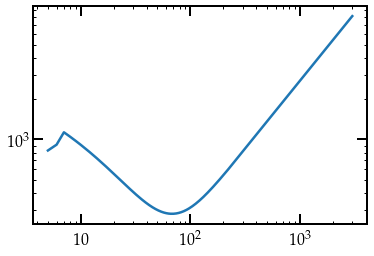

In [51]:
plt.figure()

plt.loglog()

plt.plot(rs_vec, test2[:,0]/phys.kB)

In [53]:
?main.evolve

In [24]:
test

array([[7.04232739e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       [7.04126271e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       [7.03891275e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       ...,
       [9.04744350e-05, 1.90694083e-04, 9.99998695e-13, 9.99998695e-13],
       [6.65100843e-05, 1.88570323e-04, 9.99998695e-13, 9.99998695e-13],
       [4.62064135e-05, 1.86229989e-04, 9.99998695e-13, 9.99998695e-13]])